In [1]:
import h5py, os
import numpy as np

from msfm.utils import files, observation, cross_statistics
from deep_lss.utils import configuration
from msi.utils import preprocessing, plotting

# find sobol indices closest to Buzzard cosmology

In [2]:
meta_file = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/data/CosmoGridV1_metainfo.h5"
with h5py.File(meta_file, "r") as f:
    print(f.keys())
    print(f["parameters"].keys())

    grid_params = f["parameters/grid"][:]

<KeysViewHDF5 ['parameters', 'shell_info', 'simulations']>
<KeysViewHDF5 ['all', 'benchmark', 'fiducial', 'grid']>


In [3]:
buzzard_cosmo = np.array([0.286, 0.82, -1])
i_sobols = grid_params["sobol_index"]

cosmo_params = ["Om", "s8", "w0"]
grid_cosmo = np.stack([grid_params[param] for param in cosmo_params], axis=-1)

param_min = grid_cosmo.min(axis=0)
param_max = grid_cosmo.max(axis=0)
grid_cosmo_normalized = (grid_cosmo - param_min) / (param_max - param_min)

buzzard_cosmo_normalized = (buzzard_cosmo - param_min) / (param_max - param_min)

In [4]:
# distances = np.linalg.norm(grid_cosmo_normalized - buzzard_cosmo_normalized, axis=1)
distances = np.linalg.norm(grid_cosmo - buzzard_cosmo, axis=1)

n = 5
closest_indices = np.argsort(distances)[:n]
closest_sobols = i_sobols[closest_indices]
closest_points = grid_cosmo[closest_indices]

print("closest", n, "points:\n", closest_points)
print("distances", distances[closest_indices])
print("indices:", closest_indices)
print("i_sobols:", closest_sobols)

closest 5 points:
 [[ 0.28362122  0.83476105 -1.0074589 ]
 [ 0.30283051  0.83092728 -0.99843534]
 [ 0.27389526  0.8223175  -0.9670023 ]
 [ 0.26190033  0.84841385 -0.99930017]
 [ 0.28247681  0.81880798 -0.96094844]]
distances [0.01670875 0.02012758 0.03522419 0.03726434 0.03922828]
indices: [1954 2307 1483 2380 1585]
i_sobols: [114996 172798  40100 184644  57908]


# load Buzzard $C_\ell$ best fit

In [5]:
cls_dir =  "/pscratch/sd/a/athomsen/run_files/v14/cls/lensing=False,clustering=True,standard=False,log=True,cosine=False,steps=400000/32mpc_sigmoid/likelihood_flow"
params = ["Om", "s8", "w0", "bg1", "bg2", "bg3", "bg4"]
bgs = [f"bg{i}" for i in range(1,5)]

buzzard_indices = list(range(0, 16))
buzzard_indices.remove(1)
tomo_bg_single_buzzard = []
for i in buzzard_indices:
    chain = np.load(os.path.join(cls_dir, f"chain_Buzzard_{i}.npy"))
    log_probs = np.load(os.path.join(cls_dir, f"log_probs_Buzzard_{i}.npy"))
    
    MAP_params = chain[np.argmax(log_probs)]
    MAP_dict = {p: np.round(v, 3) for p, v in zip(params, MAP_params)}
    # print(f"MAP parameters: " + str({p: np.round(v, 3) for p, v in zip(params, MAP_params)}))

    tomo_bg_single_buzzard.append([MAP_dict[bg] for bg in bgs])

tomo_bg_buzzard_flock = np.stack(tomo_bg_single_buzzard, axis=0)
print(tomo_bg_buzzard_flock)

[[0.893 1.034 1.087 1.145]
 [1.261 1.516 1.59  1.656]
 [0.962 1.1   1.161 1.259]
 [1.115 1.252 1.351 1.376]
 [1.828 2.079 2.258 2.292]
 [1.119 1.302 1.406 1.456]
 [2.485 2.756 2.948 2.968]
 [1.624 1.858 1.954 2.031]
 [0.909 1.042 1.083 1.132]
 [0.924 1.076 1.137 1.2  ]
 [0.996 1.141 1.245 1.309]
 [1.094 1.276 1.313 1.371]
 [1.776 2.011 2.12  2.163]
 [1.051 1.225 1.348 1.414]
 [1.113 1.312 1.375 1.404]]


In [6]:
mock = f"Buzzard_mean"
chain = np.load(os.path.join(cls_dir, f"chain_{mock}.npy"))
log_probs = np.load(os.path.join(cls_dir, f"log_probs_{mock}.npy"))

MAP_params = chain[np.argmax(log_probs)]
MAP_dict = {p: np.round(v, 3) for p, v in zip(params, MAP_params)}

tomo_bg_buzzard_mean = np.array([MAP_dict[bg] for bg in bgs])
print(tomo_bg_buzzard_mean)

[1.127 1.303 1.37  1.454]


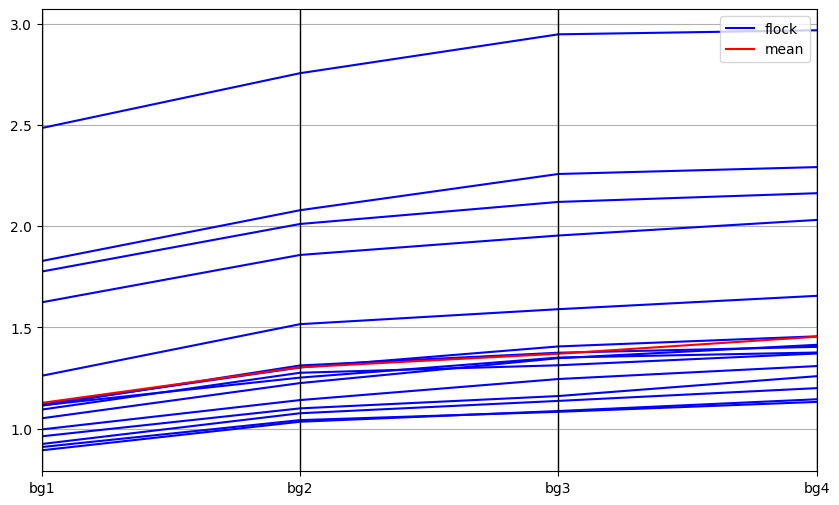

In [7]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

df = pd.DataFrame(tomo_bg_buzzard_flock, columns=bgs)
df['label'] = 'flock'
point_df = pd.DataFrame([tomo_bg_buzzard_mean.flatten()], columns=bgs)
point_df['label'] = 'mean'
full_df = pd.concat([df, point_df], ignore_index=True)

plt.figure(figsize=(10, 6))
parallel_coordinates(full_df, 'label', color=['blue', 'red'])
plt.grid(True)
plt.show()

In [10]:
# tomo_bg_buzzard = tomo_bg_buzzard_mean
i_buzzard = 3
tomo_bg_buzzard = tomo_bg_buzzard_flock[i_buzzard]
print(tomo_bg_buzzard)

[1.115 1.252 1.351 1.376]


# forward model maps according to Buzzard $C_\ell$ best fit

In [11]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml")
label = "8,32mpc"
dlss_conf = configuration.load_deep_lss_config(
    f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/combined/dlss_{label}.yaml"
)
cosmogrid_dir = "/global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid"
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended"

with_lensing = True
with_clustering = True

25-06-06 02:18:35 configuratio INF   Loaded the config 


In [12]:
# %%time

closest_sobol = closest_sobols[0]
cosmo_dir = os.path.join(cosmogrid_dir, f"cosmo_{closest_sobol:06d}")
perm_dir = os.path.join(cosmo_dir, f"perm_{0:04d}")

wl_gamma_patch, gc_count_patch = observation.forward_model_cosmogrid(
    perm_dir,
    conf=msfm_conf,
    noisy=True,
    # lensing
    with_lensing=with_lensing,
    tomo_Aia=None,
    bta=None,
    i_sobol=closest_sobol,
    # clustering
    with_clustering=with_clustering,
    tomo_bg=tomo_bg_buzzard,
    noise_seed=12,
)

25-06-06 02:18:35 observation. INF   Starting with the weak lensing map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0000/projected_probes_maps_v11dmb.h5 
25-06-06 02:22:11 observation. INF   Using tomo_Aia=[0.38089597 0.46084908 0.5600504  0.65948504] from the config 
25-06-06 02:22:11 observation. INF   Using bta=0.0 from the config 
25-06-06 02:22:11 observation. INF   Using delta-NLA 
25-06-06 02:22:13     files.py INF   Loaded the noise file 
25-06-06 02:22:27 observation. INF   Finished weak lensing after 0:03:51.82 
25-06-06 02:22:27 observation. INF   Starting with the galaxy clustering map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0000/projected_probes_maps_v11dmb.h5 
25-06-06 02:23:09 observation. INF   Using tomo_bg=[1.115 1.252 1.351 1.376] from the function call 
25-06-06 02:23:09 observation. INF   No quadratic biasing 
25-06-06 02:23:10 observation. INF   Finished galaxy 

In [13]:
%%time

obs_map, obs_cls, footprint_pix = observation.forward_model_observation_map(
    wl_gamma_map=wl_gamma_patch,
    gc_count_map=gc_count_patch,
    conf=msfm_conf,
    apply_norm=True,
    with_padding=True,
    nest_in=False,
)

No normalization applied to the galaxy clustering maps
CPU times: user 49.8 s, sys: 7.83 s, total: 57.6 s
Wall time: 7.3 s


25-06-06 02:23:17 configuratio INF   Loaded the config 
25-06-06 02:23:17 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-06 02:23:17 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-06 02:23:17 preprocessin INF   Adding white noise to the observation 
25-06-06 02:23:17 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 
25-06-06 02:23:17 preprocessin INF   Taking the logarithm of the absolute values. 
CPU times: user 351 ms, sys: 366 ms, total: 718 ms
Wall time: 443 ms


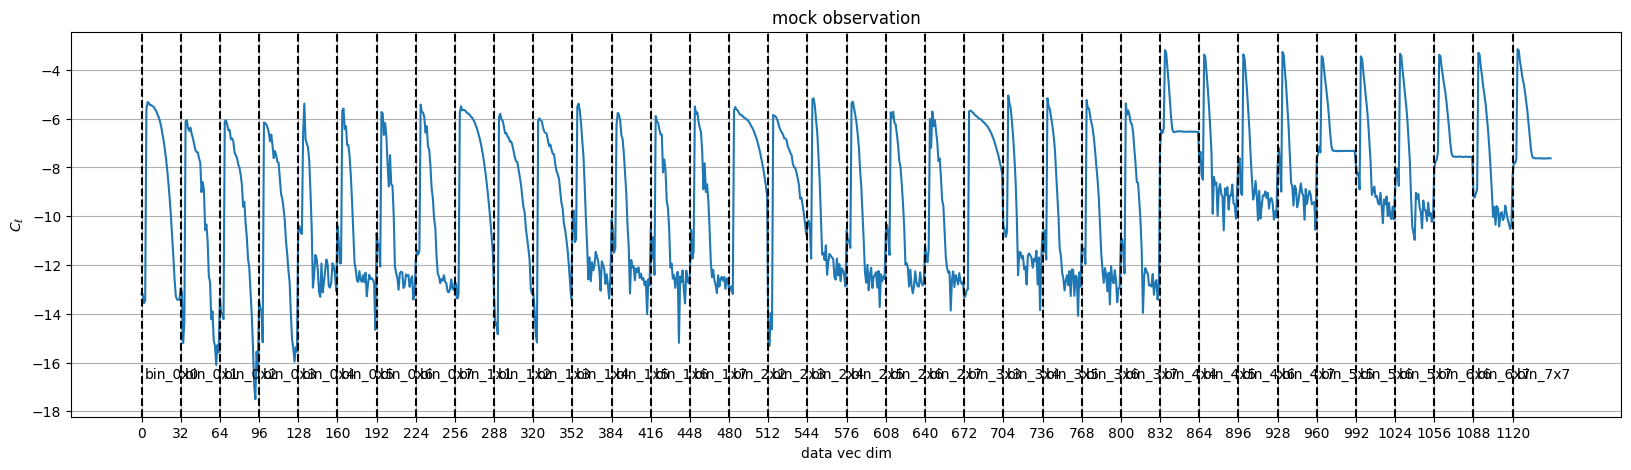

In [14]:
%%time

obs_cls = preprocessing.get_preprocessed_cl_observation(
    obs_cl=obs_cls,
    # configuration
    msfm_conf=msfm_conf,
    dlss_conf=dlss_conf,
    base_dir=base_dir,
    # selection
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_cross_z=True,
    with_cross_probe=(with_lensing and with_clustering),
    # additional preprocessing
    apply_log=True,
    standardize=False,
    # plotting
    make_plot=True,
    # obs_label=None,
)

# compare to Buzzard

In [29]:
def get_obs_cls(lensing_file, clustering_file, nest_in=False):
    # load the mock
    with h5py.File(lensing_file, "r") as f_in:
        gamma1 = []
        gamma2 = []
        for j in range(1,5):
            gamma1.append(f_in[f"metacal/raw_gamma1_bin{j}"])
            gamma2.append(f_in[f"metacal/raw_gamma2_bin{j}"])
        gamma1 = np.stack(gamma1, axis=-1)
        gamma2 = np.stack(gamma2, axis=-1)
        
        wl_map = np.stack([gamma1, gamma2], axis=-1)

    with h5py.File(clustering_file, "r") as f_in:
        gc_map = []
        for i in range(1,5):
            gc_map.append(f_in[f"maglim/galaxy_counts_bin{i}"][:])
        gc_map = np.stack(gc_map, axis=-1)

    # forward model
    obs_cls = preprocessing.get_preprocessed_cl_observation(
        wl_gamma_map=wl_map,
        gc_count_map=gc_map,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        nest_in=False,
        make_plot=False,
        # selection
        with_lensing=with_lensing,
        with_clustering=with_clustering,
        with_cross_z=True,
        # additional preprocessing
        apply_log=True,
        standardize=False,
    )

    return np.squeeze(obs_cls)

def convert_full_cls_to_probe(obs_cls, with_lensing, with_clustering):
    obs_cls_reshaped = np.stack(np.split(obs_cls, 36, axis=-1), axis=-1)

    total_indices, names = cross_statistics.get_cross_bin_indices(
        with_lensing=with_lensing, with_clustering=with_clustering, with_cross_z=True,
    )
    obs_cls_selected = obs_cls_reshaped[:,total_indices]
    obs_cls_selected = np.concatenate([obs_cls_selected[..., i] for i in range(obs_cls_selected.shape[-1])], axis=-1)

    return obs_cls_selected


In [30]:
buzzard_cls = []
if with_lensing and with_clustering:
    I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    J = [0, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 11, 11]
    K = ["a"] + 7 * ["a", "b"]
    for i, j, k in [list(zip(I, J, K))[i_buzzard]]:
    # for i, j, k in zip(I, J, K):
        lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL.h5"
        clustering_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_Buzzard_{j}_Y3{k}.h5"
        buzzard_cls.append(get_obs_cls(lensing_file, clustering_file))

buzzard_cls = np.squeeze(buzzard_cls)
# obs_cls = np.stack(obs_cls, axis=0)
# obs_cls = np.mean(obs_cls, axis=0)
# obs_cls = np.stack(np.split(obs_cls, grid_cls.shape[-1], axis=-1), axis=-1)

25-06-06 02:28:54 configuratio INF   Loaded the config 
25-06-06 02:28:54 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-06 02:28:54 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-06 02:29:01 preprocessin INF   Adding white noise to the observation 
25-06-06 02:29:01 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 
25-06-06 02:29:01 preprocessin INF   Taking the logarithm of the absolute values. 


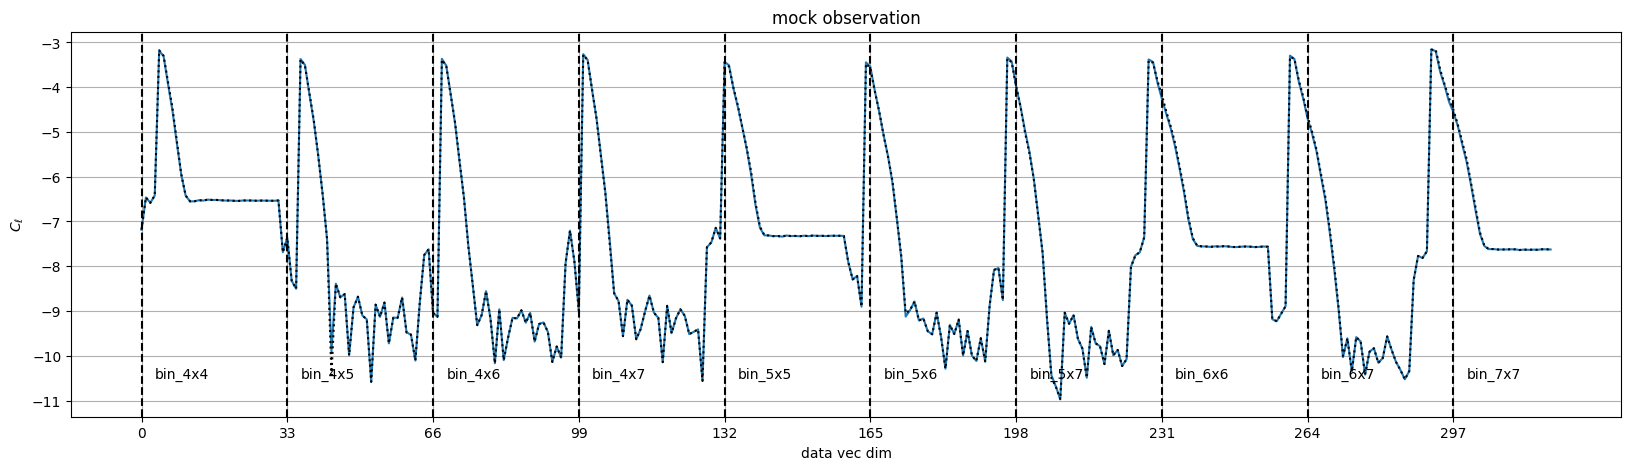

In [32]:
obs_cls_clustering = convert_full_cls_to_probe(np.squeeze(obs_cls), with_lensing=False, with_clustering=True)
buzzard_cls_clustering = convert_full_cls_to_probe(buzzard_cls, with_lensing=False, with_clustering=True)

fig, ax = plotting.plot_single_power_spectrum(
    obs_cls_clustering,
    bin_size=msfm_conf["analysis"]["power_spectra"]["n_bins"],
    yscale="linear",
    with_lensing=False,
    with_clustering=True,
    with_cross_z=True,
    with_cross_probe=False
)

ax.plot(buzzard_cls_clustering, color="k", linestyle=":")